In [1]:
# Tensorflow依赖于一个高效的C++后端来进行计算。与后端的这个连接叫做session。
#一般而言，使用TensorFlow程序的流程是先创建一个图，然后在session中启动它。

# 这里，我们使用更加方便的InteractiveSession类。
#通过它，你可以更加灵活地构建你的代码。它能让你在运行图的时候，插入一些计算图，这些计算图是由某些操作(operations)构成的。
#这对于工作在交互式环境中的人们来说非常便利，比如使用IPython。如果你没有使用InteractiveSession，那么你需要在启动session之前构建整个计算图，然后启动该计算图。

In [2]:
#计算图

# 为了在Python中进行高效的数值计算，我们通常会使用像NumPy一类的库，将一些诸如矩阵乘法的耗时操作在Python环境的外部来计算，这些计算通常会通过其它语言并用更为高效的代码来实现。

# 但遗憾的是，每一个操作切换回Python环境时仍需要不小的开销。如果你想在GPU或者分布式环境中计算时，这一开销更加可怖，这一开销主要可能是用来进行数据迁移。

# TensorFlow也是在Python外部完成其主要工作，但是进行了改进以避免这种开销。
# 其并没有采用在Python外部独立运行某个耗时操作的方式，而是先让我们描述一个交互操作图，然后完全将其运行在Python外部。这与Theano或Torch的做法类似。

#因此，Python代码的目的是用来构建这个可以在外部运行的计算图，以及安排计算图的哪一部分应该被运行。

In [3]:
## 加载MNIST数据

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


## 构建一个多层卷积网络

In [5]:
# 在MNIST上只有91%正确率，此次我们用一个稍微复杂的模型：卷积神经网络来改善效果。这会达到大概99.2%的准确率。

In [2]:
import numpy as np
import tensorflow as tf

# 设置按需使用GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = False
sess = tf.InteractiveSession(config=config)

In [7]:
## 定义模型 

In [3]:
# 为输入图像和目标输出类别创建节点，来开始构建计算图。
# x和y并不是特定的值，相反，他们都只是一个占位符，可以在TensorFlow运行某一计算时根据该占位符输入具体的值。
x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])

# 为模型定义权重W和偏置b。
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
# 变量需要通过seesion初始化后，才能在session中使用。这一初始化步骤为，为初始值指定具体值（本例当中是全为零），并将其分配给每个变量,可以一次性为所有变量完成此操作。
sess.run(tf.global_variables_initializer())
# 我们把向量化后的图片x和权重矩阵W相乘，加上偏置b，然后计算每个分类的softmax概率值。
y = tf.nn.softmax(tf.matmul(x,W) + b)
# 为训练过程指定最小化误差用的损失函数，我们的损失函数是目标类别和预测类别之间的交叉熵。
cross_entropy = -tf.reduce_sum(y_*tf.log(y))

# 我们已经定义好模型和训练用的损失函数，那么用TensorFlow进行训练就很简单了。因为TensorFlow知道整个计算图，它可以使用自动微分法找到对于各个变量的损失的梯度值。
# TensorFlow有大量内置的优化算法 这个例子中，我们用最速下降法让交叉熵下降，步长为0.01.
# 用来往计算图上添加一个新操作，其中包括计算梯度，计算每个参数的步长变化，并且计算出新的参数值。
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
for i in range(1000):
  batch = mnist.train.next_batch(50)
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})
# 每一步迭代，都会加载50个训练样本，然后执行一次train_step，并通过feed_dict将x 和 y_张量占位符用训练训练数据替代。
# 在计算图中，可以用feed_dict来替代任何张量，并不仅限于替换占位符。

### 1. 权重初始化

In [9]:
# 为了创建这个模型，我们需要创建大量的权重和偏置项。
# 这个模型中的权重在初始化时应该加入少量的噪声来打破对称性以及避免0梯度。
# 由于我们使用的是ReLU神经元，因此比较好的做法是用一个较小的正数来初始化偏置项，以避免神经元节点输出恒为0的问题（dead neurons）。
# 为了不在建立模型的时候反复做初始化操作，我们定义两个函数用于初始化。

In [4]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

### 2. 卷积和池化

In [11]:
# TensorFlow在卷积和池化上有很强的灵活性。我们怎么处理边界？步长应该设多大？
# 在这个实例里，我们会一直使用vanilla版本。我们的卷积使用1步长（stride size），0边距（padding size）的模板，保证输出和输入是同一个大小。
# 我们的池化用简单传统的2x2大小的模板做max pooling。为了代码更简洁，我们把这部分抽象成一个函数。

In [12]:
# 知识点：卷积
# tf.nn.conv2d是TensorFlow里面实现卷积的函数，这是搭建卷积神经网络比较核心的一个方法，非常重要。
# tf.nn.conv2d(input, filter, strides, padding, use_cudnn_on_gpu=None, name=None)
# 除去name参数用以指定该操作的name，与方法有关的一共五个参数：
# (1). 第一个参数input：指需要做卷积的输入图像，它要求是一个Tensor，具有[batch, in_height, in_width, in_channels]这样的shape，
# 具体含义是[训练时一个batch的图片数量, 图片高度, 图片宽度, 图像通道数]，注意这是一个4维的Tensor，要求类型为float32和float64其中之一
# (2). 第二个参数filter：相当于CNN中的卷积核，它要求是一个Tensor，具有[filter_height, filter_width, in_channels, out_channels]这样的shape.
# 具体含义是[卷积核的高度，卷积核的宽度，图像通道数，卷积核个数]，要求类型与参数input相同，有一个地方需要注意，第三维in_channels，就是参数input的第四维
# (3). 第三个参数strides：卷积时在图像每一维的步长，这是一个一维的向量，长度4
# (4). 第四个参数padding：string类型的量，只能是"SAME","VALID"其中之一，这个值决定了不同的卷积方式（后面会介绍）
# (5). 第五个参数：use_cudnn_on_gpu:bool类型，是否使用cudnn加速，默认为true
# 结果返回一个Tensor，这个输出，就是我们常说的feature map

In [5]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

### 3. 第一层卷积

In [14]:
# 现在我们可以开始实现第一层了。
# 它由一个卷积接一个max pooling完成。
# 卷积在每个5x5的patch中算出32个特征。卷积的权重张量形状是[5, 5, 1, 32]，前两个维度是patch的大小，接着是输入的通道数目，最后是输出的通道数目。 
# 而对于每一个输出通道都有一个对应的偏置量。

In [6]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

In [7]:
# 为了用这一层，我们把x变成一个4d向量，其第2、第3维对应图片的宽、高，
# 最后一维代表图片的颜色通道数(因为是灰度图所以这里的通道数为1，如果是rgb彩色图，则为3)。

In [8]:
x_image = tf.reshape(x, [-1, 28, 28, 1])

In [9]:
# We then convolve x_image with the weight tensor, add the bias, apply the ReLU function, and finally max pool. 
# 我们把x_image和权值向量进行卷积，加上偏置项，然后应用ReLU激活函数，最后进行max pooling。
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

### 4.第二层卷积

In [10]:
# 为了构建一个更深的网络，我们会把几个类似的层堆叠起来。第二层中，每个5x5的patch会得到64个特征。
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

### 5.密集连接层

In [11]:
# 现在，图片尺寸减小到7x7，我们加入一个有1024个神经元的全连接层，用于处理整个图片。
# 我们把池化层输出的张量reshape成一些向量，乘上权重矩阵，加上偏置，然后对其使用ReLU。

In [12]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

### 6.Dropout

In [13]:
# 为了减少过拟合，我们在输出层之前加入dropout。
# 用一个placeholder来代表一个神经元的输出在dropout中保持不变的概率。
# 在训练过程中启用dropout，在测试过程中关闭dropout。 
# TensorFlow的tf.nn.dropout操作除了可以屏蔽神经元的输出外，还会自动处理神经元输出值的scale。所以用dropout的时候可以不用考虑scale。

In [14]:
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### 7.输出层

In [15]:
# 最后，我们添加一个softmax层
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

### 8. 训练和评估模型

In [16]:
# 为了进行训练和评估，我们使用与之前简单的单层SoftMax神经网络模型几乎相同的一套代码.
# 此次，用更加复杂的ADAM优化器来做梯度最速下降，在feed_dict中加入额外的参数keep_prob来控制dropout比例。然后每100次迭代输出一次日志。

In [ ]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())
for i in range(2000):
  batch = mnist.train.next_batch(50)
  if i%100 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g" % (i, train_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g" % accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.02


In [17]:
# 下面改成了 test 也用 mini_batch 的形式， 显存只用了 529M,所以还是很成功的。

In [25]:
# 题外话：在做这个例子的过程中遇到过：资源耗尽的错误，为什么？
# -> 因为之前每次做 train_acc  的时候用了全部的 55000 张图，显存爆了.

# 1.损失函数：cross_entropy
cross_entropy = -tf.reduce_sum(y_ * tf.log(y_conv))
# 2.优化函数：AdamOptimizer
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# 3.预测准确结果统计
#　预测值中最大值（１）即分类结果，是否等于原始标签中的（１）的位置。argmax()取最大值所在的下标
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))  
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 如果一次性来做测试的话，可能占用的显存会比较多，所以测试的时候也可以设置较小的batch来看准确率
test_acc_sum = tf.Variable(0.0)
batch_acc = tf.placeholder(tf.float32)
new_test_acc_sum = tf.add(test_acc_sum, batch_acc)
update = tf.assign(test_acc_sum, new_test_acc_sum)

# 定义了变量必须要初始化，或者下面形式
sess.run(tf.global_variables_initializer())
# 或者某个变量单独初始化 如：
# x.initializer.run()

# 训练
for i in range(2000):
    X_batch, y_batch = mnist.train.next_batch(batch_size=50)
    if i % 500 == 0:
        train_accuracy = accuracy.eval(feed_dict={x: X_batch, y_: y_batch, keep_prob: 1.0})
        print("step %d, training acc %g" % (i, train_accuracy))
    train_step.run(feed_dict={x: X_batch, y_: y_batch, keep_prob: 0.5})  

# 全部训练完了再做测试，batch_size=100
for i in range(100): 
    X_batch, y_batch = mnist.test.next_batch(batch_size=100)
    test_acc = accuracy.eval(feed_dict={x: X_batch, y_: y_batch, keep_prob: 1.0})
    update.eval(feed_dict={batch_acc: test_acc})
    if (i+1) % 20 == 0:
        print("testing step %d, test_acc_sum %g" % (i+1, test_acc_sum.eval()))
print(" test_accuracy %g" % (test_acc_sum.eval() / 100.0))

step 0, training acc 0.14
step 500, training acc 1
step 1000, training acc 0.92
step 1500, training acc 0.98
testing step 20, test_acc_sum 19.48
testing step 40, test_acc_sum 39.13
testing step 60, test_acc_sum 58.61
testing step 80, test_acc_sum 78.09
testing step 100, test_acc_sum 97.66
 test_accuracy 0.9766


### 查看中间结果

In [18]:
# 关于 Python 图片操作主要有 matplotlib 和 PIL 两个库

In [19]:
# 我们先来看看数据是什么样的
img1 = mnist.train.images[1]
label1 = mnist.train.labels[1]
print(label1)  # 所以这个是数字 6 的图片
print('img_data shape =', img1.shape)  # 我们需要把它转为 28 * 28 的矩阵


[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
img_data shape = (784,)


(28, 28)


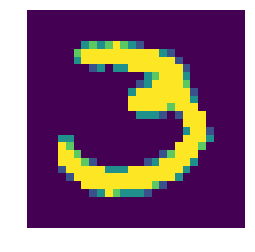

In [20]:
#转为 28 * 28 的矩阵
img1.shape = [28, 28]
import matplotlib.pyplot as plt
# import matplotlib.image as mpimg  # 用于读取图片，这里用不上
print(img1.shape)
plt.imshow(img1)
plt.axis('off') # 不显示坐标轴
plt.show()

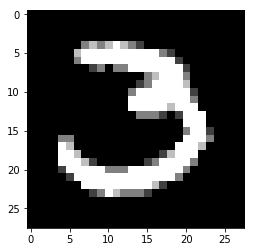

In [21]:
# 我们可以通过设置 cmap 参数来显示灰度图
plt.imshow(img1, cmap='gray') # 'hot' 是热度图
plt.show()

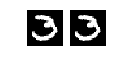

In [22]:
# 我们想看 Conv1 层的32个卷积滤波后的结果，显示在同一张图上。 python 中也有 plt.subplot(121) 这样的方法来帮我们解决这个问题。
plt.subplot(4,8,1)
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.subplot(4,8,2)
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.show()

### 显示网络中间结果

In [26]:
# 首先应该把 img1 转为正确的shape (None, 784)
X_img = img1.reshape([-1, 784])
y_img = mnist.train.labels[1].reshape([-1, 10])
# 我们要看 Conv1 的结果，即 h_conv1
result = h_conv1.eval(feed_dict={x: X_img, y_: y_img, keep_prob: 1.0})
print(result.shape)
print(type(result))

(1, 28, 28, 32)
<class 'numpy.ndarray'>


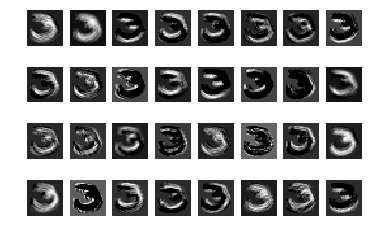

In [28]:
for _ in range(32):
    show_img = result[:,:,:,_]
    show_img.shape = [28, 28]
    plt.subplot(4, 8, _ + 1)
    plt.imshow(show_img, cmap='gray')
    plt.axis('off')
plt.show()
# 从结果来看，我们可以看到不同的滤波器（卷积核）学习到了不同的特征。
# 比如第一行中，第一个滤波器学习到了边缘信息，第5个卷积核，则学习到了骨干的信息。

In [30]:
print(mnist.train.labels[:6])

[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


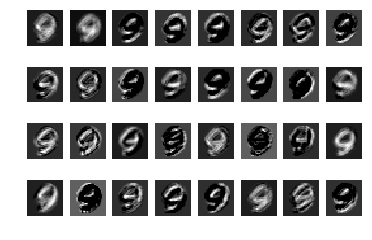

In [36]:
# 首先应该把 img1 转为正确的shape (None, 784)
X_img = mnist.train.images[4].reshape([-1, 784])
y_img = mnist.train.labels[1].reshape([-1, 10]) # 这个标签只要维度一致就行了
result = h_conv1.eval(feed_dict={x: X_img, y_: y_img, keep_prob: 1.0})

for _ in range(32):
    show_img = result[:,:,:,_]
    show_img.shape = [28, 28]
    plt.subplot(4, 8, _ + 1)
    plt.imshow(show_img, cmap='gray')
    plt.axis('off')
plt.show()